# Computational Cognitive Neuroscience: assignment 2

By: 
Emiel Stoelinga, s4837584 & Luca Parolo, s1009497

First the required libraries are imported.

In [5]:
%matplotlib inline

import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples

from utils import get_mnist

import matplotlib.pyplot as plt

We define the architecture of a neural network with one layer

In [6]:
class NN1(Chain):
    def __init__(self, n_units, n_out):
        super(NN1, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) ##from the original MLP deleted the hidden layer. Now only input-output.
            
            self.l2 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x)) ##from the original MLP, deleted one line,the outcome of the activation function is directly 
        y = self.l2(h1)         ##passed to the output layer without further computation ( as there is no hidden layer now)
        return y

We define the architecture of a neural network with two layer, which is a Multilayer Perceptron

In [7]:
class NN2(Chain):
    def __init__(self, n_units, n_out):
        super(NN2, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

We define the architecture of a neural network with three layer

In [8]:
class NN3(Chain):
    def __init__(self, n_units, n_out):
        super(NN3, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) ##from the original MLP added one hidden layer
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_units)
            self.l4 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))  
        h2 = F.relu(self.l2(h1))   
        h3 = F.relu(self.l3(h2))
        y = self.l4(h3)         
        return y

We build a training function and we store the training loss and the validation losses for each epoch, which we will plot later to compare the three different architecures.

In [9]:
def run(train_iter, val_iter, test_data, model, optimizer, max_epoch):
    training_losses = []
    validation_losses = []
    
    mini_batch_losses = []

    while train_iter.epoch < max_epoch:
        # Get next mini-batch
        batch = train_iter.next()
        image_train, target_train = concat_examples(batch)

        # Prediction
        prediction_train = model(image_train)

        # Compute loss
        loss = F.softmax_cross_entropy(prediction_train, target_train)
        mini_batch_losses.append(loss.data)

        # Compute gradients
        model.cleargrads()
        loss.backward()

        # Update variables
        optimizer.update()

        # Check the validation accuracy of prediction after every epoch
        if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

            # Save the training loss
            training_losses.append(np.mean(mini_batch_losses))
            mini_batch_losses = []

            val_losses = []
            val_accuracies = []
            while True:
                val_batch = val_iter.next()
                image_val, target_val = concat_examples(val_batch)

                # Forward the validation data
                prediction_val = model(image_val)

                # Calculate the loss
                loss_val = F.softmax_cross_entropy(prediction_val, target_val)
                val_losses.append(loss_val.data)

                # Calculate the accuracy
                accuracy = F.accuracy(prediction_val, target_val)
                val_accuracies.append(accuracy.data)

                if val_iter.is_new_epoch:
                    val_iter.epoch = 0
                    val_iter.current_position = 0
                    val_iter.is_new_epoch = False
                    val_iter._pushed_position = None

                    validation_losses.append(np.mean(val_losses))
                    break

    # Predict full test set
    image_test, target_test = concat_examples(test_data)
    # Forward test data
    prediction_test = model(image_test)
    # Calculate loss and accuracy
    loss_test = F.softmax_cross_entropy(prediction_test, target_test)
    accuracy_test = F.accuracy(prediction_test, target_test)

    print('test_loss: ' + str(loss_test.data) + ' test_accuracy: ' + str(accuracy_test.data))
    return training_losses, validation_losses

Then in our main function we define three different Neural Network( NN1,NN2,NN3), each with 10 neurons per layer (input, hidden or output). We train each of the NN ,with the MNIST dataset for 20 epoch. Lastly we plot the training loss and the validation loss for each epoch for each NN to compare their efficacy. 

test_loss: 1.11467003822 test_accuracy: 0.704999983311
test_loss: 1.38040602207 test_accuracy: 0.559000015259
test_loss: 1.56851744652 test_accuracy: 0.490999996662


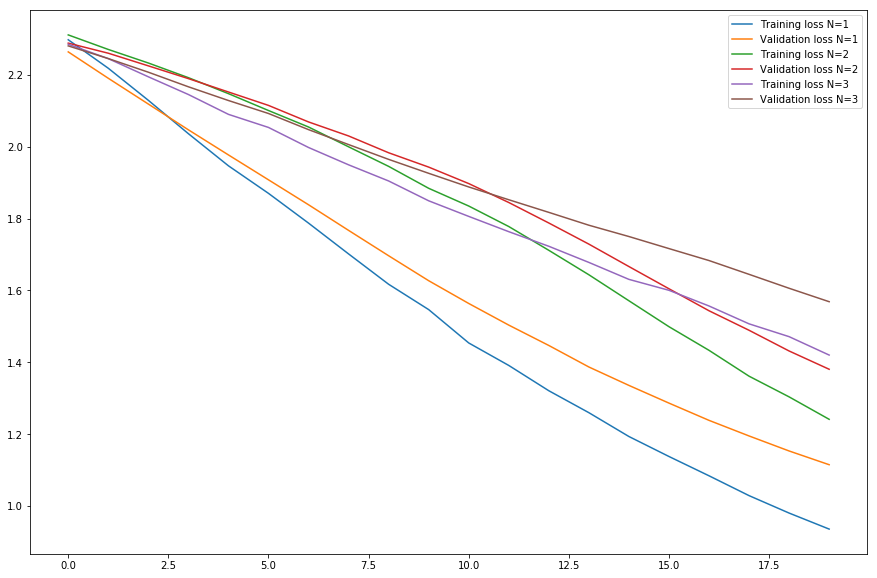

In [24]:
def main():
    # Load data
    train, test = get_mnist()
    
    # Initialize iterators
    train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
    val_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

    # Define model NN1
    model = NN1(10, 10) ##10 neurons per layer
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    plt.figure(figsize=(15,10))
    
    training_losses, validation_losses = run(train_iter, val_iter, test, model, optimizer, 20) ##Max Epoch 20
    
    plt.plot(training_losses, label='Training loss N=1')
    plt.plot(validation_losses, label='Validation loss N=1')
    plt.legend()
    
    train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
    val_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

    # Define model NN2 
    model = NN2(10, 10) ##10 neurons per layer
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    training_losses, validation_losses = run(train_iter, val_iter, test, model, optimizer, 20) ##Max Epoch 20
    
    plt.plot(training_losses, label='Training loss N=2')
    plt.plot(validation_losses, label='Validation loss N=2')
    plt.legend()
    
    train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
    val_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

    # Define model NN3
    model = NN3(10, 10) ##10 neurons per layer
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    training_losses, validation_losses = run(train_iter, val_iter, test, model, optimizer, 20) ##Max Epoch 20
    
    
    plt.plot(training_losses, label='Training loss N=3')
    plt.plot(validation_losses, label='Validation loss N=3')
    plt.legend()

if __name__ == "__main__":
    main()

As we see, all three NNs improve their performance epoch after epoch. The best performing NN is surprisngly the simple one ( we run the code multiple times and its always the best performing one). 

## Question 2

A small convolutional network consisiting of one convolutional layer, a max pooling layer and a fully connected layer should be constructed and should be trained on the MNIST dataset.

First, a class is constructed which represents the network.

In [7]:
class SmallConv(Chain):
    def __init__(self, n_out):
        super(SmallConv, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, out_channels=5, ksize=5, stride=1, pad=0) # Convolutional layer
            self.fc1 = L.Linear(None, n_out) # Fully connected layer

    def __call__(self, x):
        h1 = self.conv1(x)
        h2 = F.max_pooling_2d(h1, ksize=5, stride=1, pad=0) # Max pooling layer
        y = self.fc1(h2)
        return y

In order to train the network, a training function is built. For every epoch, the function forwards a new mini-batch through the network, computes the loss and backwards the loss through the network such that variables can be updated. Furthermore, the network is evaluated by forwarding the test set of 100 images through it.

For both operations, the loss is printed and stored, such that it can be plotted after training. 

In [8]:
def run(train_iter, val_iter, test_data, model, optimizer, max_epoch):
    training_losses = []
    validation_losses = []
    
    mini_batch_losses = []

    while train_iter.epoch < max_epoch:
        # Get next mini-batch
        batch = train_iter.next()
        image_train, target_train = concat_examples(batch)

        # Prediction
        prediction_train = model(image_train)

        # Compute loss
        loss = F.softmax_cross_entropy(prediction_train, target_train)
        mini_batch_losses.append(loss.data)

        # Compute gradients
        model.cleargrads()
        loss.backward()

        # Update variables
        optimizer.update()

        # Check the validation accuracy of prediction after every epoch
        if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

            # Save the training loss
            training_losses.append(np.mean(mini_batch_losses))
            mini_batch_losses = []

            val_losses = []
            val_accuracies = []
            while True:
                val_batch = val_iter.next()
                image_val, target_val = concat_examples(val_batch)

                # Forward the validation data
                prediction_val = model(image_val)

                # Calculate the loss
                loss_val = F.softmax_cross_entropy(prediction_val, target_val)
                val_losses.append(loss_val.data)

                # Calculate the accuracy
                accuracy = F.accuracy(prediction_val, target_val)
                val_accuracies.append(accuracy.data)

                if val_iter.is_new_epoch:
                    val_iter.epoch = 0
                    val_iter.current_position = 0
                    val_iter.is_new_epoch = False
                    val_iter._pushed_position = None

                    validation_losses.append(np.mean(val_losses))
                    break

    # Predict full test set
    image_test, target_test = concat_examples(test_data)
    # Forward test data
    prediction_test = model(image_test)
    # Calculate loss and accuracy
    loss_test = F.softmax_cross_entropy(prediction_test, target_test)
    accuracy_test = F.accuracy(prediction_test, target_test)

    print('test_loss: ' + str(loss_test.data) + ' test_accuracy: ' + str(accuracy_test.data))
    return training_losses, validation_losses

The full proces is run in the main function. First, the data is downloaded. Then, iterators are constructed which iterate over the data for every epoch. Then the model and the optimizer are constructed and last, the model is trained. 

test_loss: 0.33282366395 test_accuracy: 0.888999998569


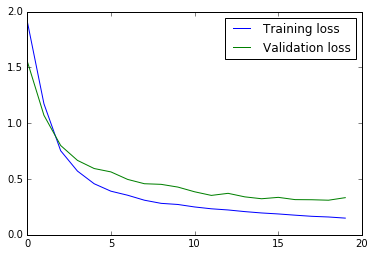

In [9]:
def main():
    # Load data
    train, test = get_mnist(n_dim=3)
    
    # Initialize iterators
    train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
    val_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

    # Define model
    model = SmallConv(10)
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    training_losses, validation_losses = run(train_iter, val_iter, test, model, optimizer, 20)
    
    plt.plot(training_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend()

if __name__ == "__main__":
    main()

## Results
Todo, also depends on results from question 1

# Question 3

The main idea behind convolution networks is to use a set of features map to represent data with higher level of complexity. For example, in an image, the convnet looks for a specific feature at different location of the image; to represent the complexity of the features of the image we use more than one feature map. This way of pattern extraction from images has its theoretical basis in humans visual system. In the '50 Hubel and Wiesel [1]  discovered that certain neurons ( later called "simple cells")in the visual cortex of cats fired when the stimulus presented was a line at a certain angle, while others fired when the line presented was at a different angle. On the other hand, other neurons ( later called "complex cells") of the visual system could detect edges despite their different location on the receptive field of the neuron. The way the visual system extract information from a stimulus , its also due to its hierarchical architecure. In fact according to Hubel and Wiesel , the responses from complex cells , are generated from the summation of responses of multiple simple cells in the initial areas of visual cortex (the higher in the computational chain of neurons in the visual cortex, the more the features extracted by simple cells are integrated in the image of the stimulus): a series of simple and complex cells is called a gnostic unit.
As we see the convnets architecture has many similarities with our visual system. It has:
- Multiple layers which are hierachically structured for features extraction.
- Local receptive field ( a neuron is sensible to a certain area of the image/visual field)
- Spatial invariance

To sum up, convolutional networks are hierachical, beacause the world, or at least the way we interpret it, is compositional, and this seemed a good way to build a machine which can interpret a complex representation of reality (such as an image).

On the other hand, convolutional neural networks works in ways that have yet to be seen in human visual system.
The computational models ( the way the system works) are differents. Convolution operation, shared weights or pooling have their meaning in the architecture of convolutional networks, but may not be the case for biological visual system. 
This may look obvious: human brain is made of living cells, its the outcome of 3 billions years of evolution of life and has billions of synaptic connections. Therefore convnets are a mere mathematical approximation of a complex computational system, embedded in a biological machine, the human body.

As stated by Lecun, "the [biological] neural inspiration in models like convolutional nets is very tenuous. That's why I call them 'convolutional nets' not 'convolutional neural nets', and why we call the nodes 'units' and not 'neurons' ".


[1] "Receptive fields, binocular interaction and functional architecture in the cat's visual cortex" D. H. Hubel and T. N. Wiesel, 1962

### Sources
Chainer: Example: Multi-layer Perceptron on MNIST
https://docs.chainer.org/en/stable/tutorial/basic.html#example-multi-layer-perceptron-on-mnist

Chainer: Write a training loop
https://docs.chainer.org/en/stable/tutorial/train_loop.html#write-a-training-loop

Convolutional Network for Visual Recognition Tasks
https://docs.chainer.org/en/stable/tutorial/convnet.html